# COMS4995 Applied Deep Learning Course Project
# UNI:
# Lishenzhen Deng
# Jiliang Ni

## About

This starter code shows how to read slides and tumor masks from the [CAMELYON16](https://camelyon17.grand-challenge.org/Data/) dataset. It will install [OpenSlide](https://openslide.org/) in Colab (the only non-Python dependency). Note that OpenSlide also includes a [DeepZoom viewer](https://github.com/openslide/openslide-python/tree/master/examples/deepzoom), shown in class. To use that, you'll need to install and run OpenSlide locally on your computer.

### Training data

The original slides and annotations are in an unusual format. I converted a bunch of them for you, so you can read them with OpenSlide as shown in this notebook. This [folder](https://drive.google.com/drive/folders/1rwWL8zU9v0M27BtQKI52bF6bVLW82RL5?usp=sharing) contains all the slides and tumor masks I converted (and these should be *plenty* for your project). If you'd like more beyond this, you'll need to use ASAP as described on the competition website to convert it into an appropriate format. 

Note that even with the starter code, it will take some effort to understand how to work with this data (the various zoom levels, and the coordinate system). Happy to help if you're stuck (please catch me in office hours, or right after class).

### Goals and grading

The goal for your project is to build a thoughtful, end-to-end prototype - not to match the accuracy from the [paper](https://arxiv.org/abs/1703.02442), and not necessarily to use all the available data. To receive an A on this work, your project should (for example):
- Use multiple zoom levels
- Use high-magnification images
- Include several visualizations of your results (both heatmaps showing predictions on individual slides, and other metrics/diagrams you design that are appropriate to communicate how well your model performs).

You are also welcome to propose a custom project of similar scope, happy to chat with you about your ideas anytime.

###Functions

In [ ]:
# Install the OpenSlide C library and Python bindings
# After installing these libraries, use `Runtime -> restart and run all` on the menu
!apt-get install openslide-tools
!pip install openslide-python

E: dpkg was interrupted, you must manually run 'dpkg --configure -a' to correct the problem. 


In [ ]:
%matplotlib inline
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from openslide import open_slide, __library_version__ as openslide_version
import os
import time
from PIL import Image
from skimage.color import rgb2gray
from sklearn.model_selection import train_test_split

In [ ]:
import tensorflow as tf
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Dense, Embedding, Flatten, Input, LSTM, BatchNormalization,Dropout
from tensorflow.keras.models import Model, Sequential
from tensorflow.keras.utils import plot_model

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
# Donwload tumor and tumor mask to Google drive to same space
# with open("/content/drive/MyDrive/CAMELYON16/wsi-urls.txt") as file:
#   lines = file.readlines()
# for line in lines:
#   if line.endswith(".tif\n"):
#     line = line.strip()
#     if "mask" in line:
#       !cd tumor_mask; curl -O $line ; cd ..;
#     else:
#       !cd tumor; curl -O $line ; cd ..;
# !cp -vr tumor /content/drive/MyDrive/CAMELYON16
# !cp -vr tumor_mask /content/drive/MyDrive/CAMELYON16

In [ ]:
IMAGE_SIZE = 299
BATCH_SIZE = 32
SHUFFLE_SIZE = 1000
AUTOTUNE = tf.data.experimental.AUTOTUNE

In [ ]:
def read_slide(slide, x, y, level, width, height, as_float=False):
    im = slide.read_region((x,y), level, (width, height))
    im = im.convert('RGB') # drop the alpha channel
    if as_float:
        im = np.asarray(im, dtype=np.float32)
    else:
        im = np.asarray(im)
    assert im.shape == (height, width, 3)
    return im
def find_tissue_pixels(image, intensity=0.8):
    im_gray = rgb2gray(image)
    assert im_gray.shape == (image.shape[0], image.shape[1])
    indices = np.where(im_gray <= intensity)
    print(len(indices[0]))
    return list(zip(indices[0], indices[1]))
def find_tissue_pixel_percent(image, intensity=0.8):
    im_gray = rgb2gray(image)
    assert im_gray.shape == (image.shape[0], image.shape[1])
    indices = np.where(im_gray <= intensity)
    return len(indices[0])/(image.shape[0] * image.shape[1])
def apply_mask(im, mask, color=(255,0,0)):
    masked = np.copy(im)
    for x,y in mask: masked[x][y] = color
    return masked
def checkshape(img):
  return img.shape[0] == IMAGE_SIZE and img.shape[1] == IMAGE_SIZE

###Show pictures

In [ ]:
tumorslide = open_slide('/content/drive/MyDrive/CAMELYON16/tumor/tumor_094.tif')
tumor_mask = open_slide('/content/drive/MyDrive/CAMELYON16/tumor_mask/tumor_094_mask.tif')

Slide includes %d levels 9
Level 0, dimensions: (118784, 100352) downsample factor 1
Level 1, dimensions: (59392, 50176) downsample factor 2
Level 2, dimensions: (29696, 25088) downsample factor 4
Level 3, dimensions: (14848, 12544) downsample factor 8
Level 4, dimensions: (7424, 6272) downsample factor 16
Level 5, dimensions: (3712, 3136) downsample factor 32
Level 6, dimensions: (1856, 1568) downsample factor 64
Level 7, dimensions: (928, 784) downsample factor 128
Level 8, dimensions: (464, 392) downsample factor 256


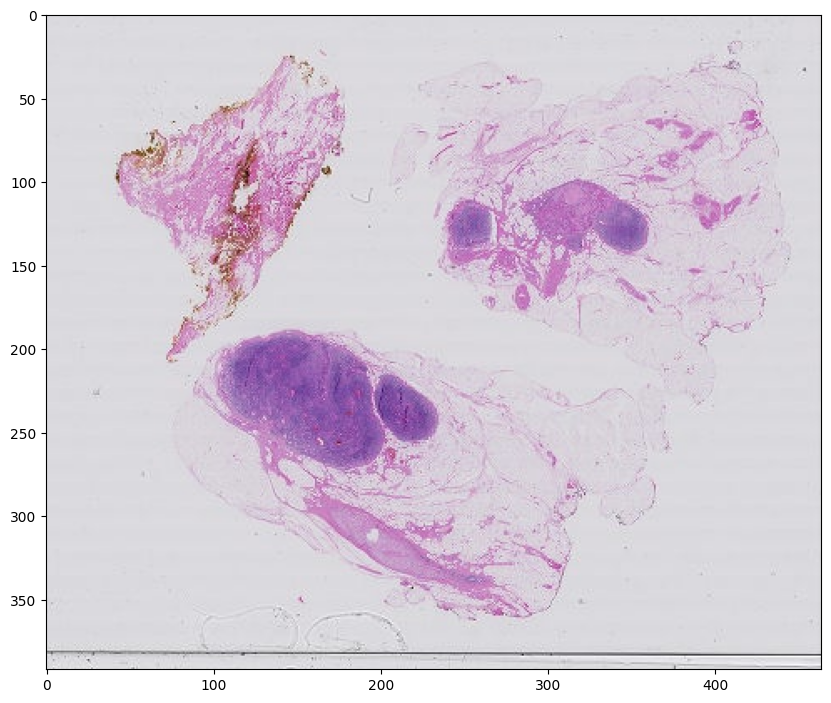

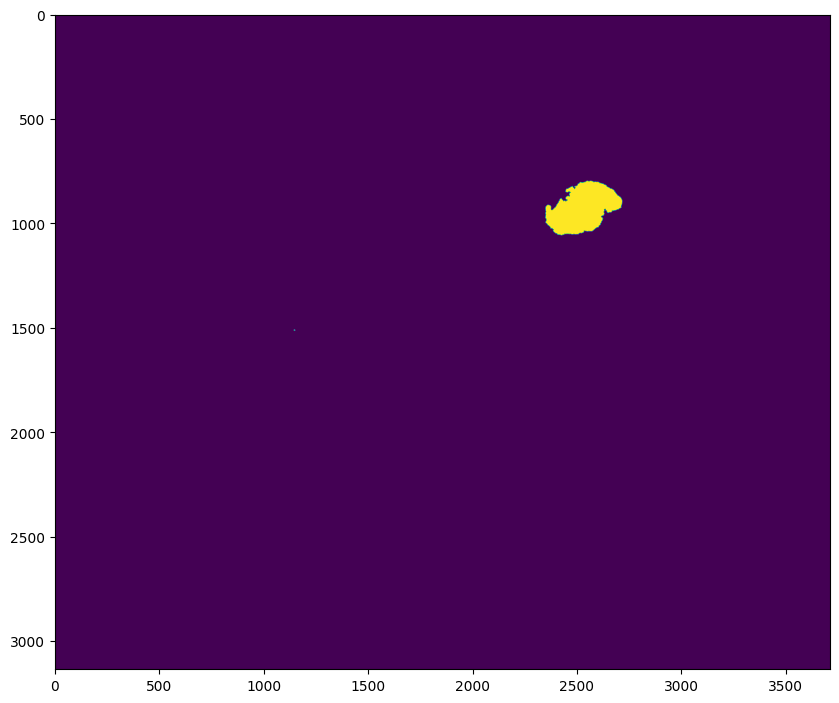

In [ ]:

print("Slide includes %d levels", len(tumorslide.level_dimensions))
for i in range(len(tumorslide.level_dimensions)):
    print("Level %d, dimensions: %s downsample factor %d" % (i, 
                                                             tumorslide.level_dimensions[i], 
                                                             tumorslide.level_downsamples[i]))
level = 8
tumorslide_image = read_slide(tumorslide, 
                         x=0, 
                         y=0, 
                         level=level, 
                         width=tumorslide.level_dimensions[level][0], 
                         height=tumorslide.level_dimensions[level][1])

plt.figure(figsize=(10,10), dpi=100)
plt.imshow(tumorslide_image)
# Example: read the entire mask at the same zoom level
mask_image = read_slide(tumor_mask, 
                        x=0, 
                        y=0, 
                        level=5, 
                        width=tumorslide.level_dimensions[5][0], 
                        height=tumorslide.level_dimensions[5][1])

# Note: the program provided by the dataset authors generates a mask with R,G,B channels.
# The mask info we need is in the first channel only.
# If you skip this step, the mask will be displayed as all black.
mask_image = mask_image[:,:,0]

plt.figure(figsize=(10,10), dpi=100)
plt.imshow(mask_image)

###Get Raw Slide Data

In [ ]:
tumor_path = "/content/drive/MyDrive/CAMELYON16/tumor/"
tumor_mask_path = "/content/drive/MyDrive/CAMELYON16/tumor_mask/"

In [ ]:
tumor = pd.DataFrame()
tumor["file"] = os.listdir(tumor_path)
tumor["path"] = tumor_path
tumor["mask"] = tumor_mask_path + tumor["file"].apply(lambda x : x.split('.')[0]+"_mask.tif")
tumor.shape

(20, 3)

In [ ]:
def getData(filedf):
    df = pd.DataFrame()
    for index,row in filedf.iterrows():
      try: 
        s = open_slide(row["path"]+row["file"])
        m = open_slide(row["mask"])
        if len(s.level_dimensions) >= 9:
          df = df.append({'file': row["file"],'slide':s,'mask':m}, ignore_index=True)
      except:
        print(row["file"])
    return df
tumor_data = getData(tumor)

In [ ]:
test_file = ["tumor_110.tif","tumor_016.tif","tumor_031.tif"]
test_data = tumor_data[tumor_data["file"].isin(test_file)].reset_index(drop=True)
train_data = tumor_data[~tumor_data["file"].isin(test_file)].reset_index(drop=True)

In [ ]:
def df_to_imgs_labels(data_df):
  level5_images = []
  level6_images = []
  level7_images = []
  labels = []
  for index, row in data_df.iterrows():
    base_level = 5
    level5_image = read_slide(row["slide"], x=0, y=0, level=5, 
                         width=row["slide"].level_dimensions[5][0], 
                         height=row["slide"].level_dimensions[5][1])
    level6_image = read_slide(row["slide"], x=0, y=0, level=6, 
                         width=row["slide"].level_dimensions[6][0], 
                         height=row["slide"].level_dimensions[6][1])
    level7_image = read_slide(row["slide"], x=0, y=0, level=7, 
                         width=row["slide"].level_dimensions[7][0], 
                         height=row["slide"].level_dimensions[7][1])
    mask_image = read_slide(row["mask"], x=0, y=0, level=base_level, 
                         width=row["slide"].level_dimensions[base_level][0], 
                         height=row["slide"].level_dimensions[base_level][1])
    mask_image = mask_image[:,:,0]
    w = int(level5_image.shape[0]/100) - 1
    h = int(level5_image.shape[1]/100) - 1
    for i in range(1,w):
      for j in range(1,h):
        pixel = level5_image[i*100:i*100+100,j*100:j*100+100,:]
        pmask = mask_image[i*100:i*100+100,j*100:j*100+100]
        if find_tissue_pixel_percent(pixel) > 0.4:
          level5_sample = level5_image[i*100-100:i*100-100+IMAGE_SIZE,j*100-100:j*100-100+IMAGE_SIZE,:]
          level6_sample = level6_image[i*50-125:i*50-125+IMAGE_SIZE,j*50-125:j*50-125+IMAGE_SIZE,:]
          level7_sample = level7_image[i*25-137:i*25-137+IMAGE_SIZE,j*25-137:j*25-137+IMAGE_SIZE,:]
          if checkshape(level5_sample) and checkshape(level6_sample) and checkshape(level7_sample):
            level5_images.append(level5_sample)
            level6_images.append(level6_sample)
            level7_images.append(level7_sample)
            labels.append(np.max(pmask)) 
  return level5_images,level6_images,level7_images,labels

In [ ]:
start = time.time()
level5_images,level6_images,level7_images,labels = df_to_imgs_labels(train_data)
print("using ",time.time() - start,"s")

using  28.804991006851196 s


In [ ]:
len(level6_images)

1468

In [ ]:
train_level5_images, valid_level5_images,train_level6_images, valid_level6_images,train_level7_images, valid_level7_images,train_lable, valid_lable, = train_test_split(
    level5_images,level6_images,level7_images,labels,test_size=0.2)

In [ ]:
lables=np.array(train_lable)
tumor_indices=np.nonzero((lables==1).astype(int))[0]
normal_indices=np.nonzero((lables==0).astype(int))[0]
print("Size of dataset: ", len(lables))
print("Cancerous patches: ", len(tumor_indices))
print("Non-cancerous patches: ", len(normal_indices))

Size of dataset:  1174
Cancerous patches:  191
Non-cancerous patches:  983


In [ ]:
# agument for tumor images
def generate_agument_images(images,indexs):
  result = []
  for i in indexs:
    result.append(np.rot90(images[i]))
    result.append(np.flip(images[i], axis=0))
    result.append(255-images[i])
  return result

####Prepare tf.dataset for only level5 training and validation data

In [ ]:
agument_imgs = generate_agument_images(train_level5_images,tumor_indices)
train_agument_level5_images = train_level5_images + agument_imgs
train_agument_label = train_lable + [1]*len(agument_imgs)

In [ ]:
# a dataset that returns valid images
start = time.time()
valid_level5_ds = tf.data.Dataset.from_tensor_slices(valid_level5_images)
for n, img_path in enumerate(valid_level5_ds.take(4)):
  print(n, img_path.shape)
time.time() - start

0 (299, 299, 3)
1 (299, 299, 3)
2 (299, 299, 3)
3 (299, 299, 3)


38.474355936050415

In [ ]:
# a dataset that returns valid labels
valid_label_ds = tf.data.Dataset.from_tensor_slices(valid_lable)

In [ ]:
# a dataset that returns train images
start = time.time()
train_level5_agument_ds = tf.data.Dataset.from_tensor_slices(train_agument_level5_images)
for n, img_path in enumerate(train_level5_agument_ds.take(4)):
  print(n, img_path.shape)
time.time() - start

0 (299, 299, 3)
1 (299, 299, 3)
2 (299, 299, 3)
3 (299, 299, 3)


193.7385540008545

In [ ]:
# a dataset that returns train labels
train_label_agument_ds = tf.data.Dataset.from_tensor_slices(train_agument_label)
for n, img_path in enumerate(train_label_agument_ds.take(4)):
  print(n, img_path)

0 tf.Tensor(0, shape=(), dtype=int32)
1 tf.Tensor(1, shape=(), dtype=int32)
2 tf.Tensor(0, shape=(), dtype=int32)
3 tf.Tensor(0, shape=(), dtype=int32)


In [ ]:
train_level5_label_ds = tf.data.Dataset.zip((train_level5_agument_ds, train_label_agument_ds))
train_level5_label_ds = train_level5_label_ds.shuffle(SHUFFLE_SIZE)
train_level5_label_ds = train_level5_label_ds.batch(BATCH_SIZE).prefetch(buffer_size=AUTOTUNE)

In [ ]:
valid_level5_label_ds = tf.data.Dataset.zip((valid_level5_ds, valid_label_ds))
valid_level5_label_ds = valid_level5_label_ds.shuffle(SHUFFLE_SIZE)
valid_level5_label_ds = valid_level5_label_ds.batch(BATCH_SIZE).prefetch(buffer_size=AUTOTUNE)

####Prepare tf.dataset for Multi Layer (level5,level6,level7) training and validation data

In [ ]:
# The following data:
# train_agument_level5_images, train_agument_label, valid_level5_images, valid_lable
# Already generation coorespoding tf.dataset:
# train_level5_agument_ds, train_label_agument_ds, valid_level5_ds, valid_label_ds
# and we need to gnereate the tf.dataset for:
# train_agument_level6_images, train_agument_level7_images, valid_level6_images, valid_level7_images

agument_imgs = generate_agument_images(train_level6_images,tumor_indices)
train_agument_level6_images = train_level6_images + agument_imgs

agument_imgs = generate_agument_images(train_level7_images,tumor_indices)
train_agument_level7_images = train_level7_images + agument_imgs

In [ ]:
# train_agument_level6_images to train_level6_agument_ds
start = time.time()
train_level6_agument_ds = tf.data.Dataset.from_tensor_slices(train_agument_level6_images)
time.time() - start

194.93475723266602

In [ ]:
# train_agument_level7_images to train_level7_agument_ds
start = time.time()
train_level7_agument_ds = tf.data.Dataset.from_tensor_slices(train_agument_level7_images)
time.time() - start

193.28752875328064

In [ ]:
# valid_level6_images to valid_level6_ds
start = time.time()
valid_level6_ds = tf.data.Dataset.from_tensor_slices(valid_level6_images)
time.time() - start

33.19856786727905

In [ ]:
# valid_level6_images to valid_level6_ds
start = time.time()
valid_level7_ds = tf.data.Dataset.from_tensor_slices(valid_level7_images)
time.time() - start

32.9375159740448

In [ ]:
train_multi_layer_label_ds = tf.data.Dataset.zip((train_level5_agument_ds,train_level6_agument_ds,train_level7_agument_ds))
train_multi_layer_label_ds = tf.data.Dataset.zip((train_multi_layer_label_ds, train_label_agument_ds))
train_multi_layer_label_ds = train_multi_layer_label_ds.shuffle(SHUFFLE_SIZE)
train_multi_layer_label_ds = train_multi_layer_label_ds.batch(BATCH_SIZE).prefetch(buffer_size=AUTOTUNE)

valid_multi_layer_label_ds = tf.data.Dataset.zip((valid_level5_ds,valid_level6_ds,valid_level7_ds))
valid_multi_layer_label_ds = tf.data.Dataset.zip((valid_multi_layer_label_ds, valid_label_ds))
valid_multi_layer_label_ds = valid_multi_layer_label_ds.shuffle(SHUFFLE_SIZE)
valid_multi_layer_label_ds = valid_multi_layer_label_ds.batch(BATCH_SIZE).prefetch(buffer_size=AUTOTUNE)

###Generate models

#####Base model

In [ ]:
from tensorflow.keras.applications.inception_v3 import InceptionV3
base_model = tf.keras.Sequential()
base_model.add(InceptionV3(weights='imagenet',
                  include_top=False,
                  input_shape=(IMAGE_SIZE, IMAGE_SIZE, 3)))
base_model.add(Dropout(0.5))
base_model.add(Flatten())
base_model.add(Dense(4, activation='relu'))
base_model.add(Dense(1, activation='sigmoid'))

base_model.summary()

Model: "sequential_5"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
inception_v3 (Functional)    (None, 8, 8, 2048)        21802784  
_________________________________________________________________
dropout (Dropout)            (None, 8, 8, 2048)        0         
_________________________________________________________________
flatten_5 (Flatten)          (None, 131072)            0         
_________________________________________________________________
dense_6 (Dense)              (None, 4)                 524292    
_________________________________________________________________
dense_7 (Dense)              (None, 1)                 5         
Total params: 22,327,081
Trainable params: 22,292,649
Non-trainable params: 34,432
_________________________________________________________________


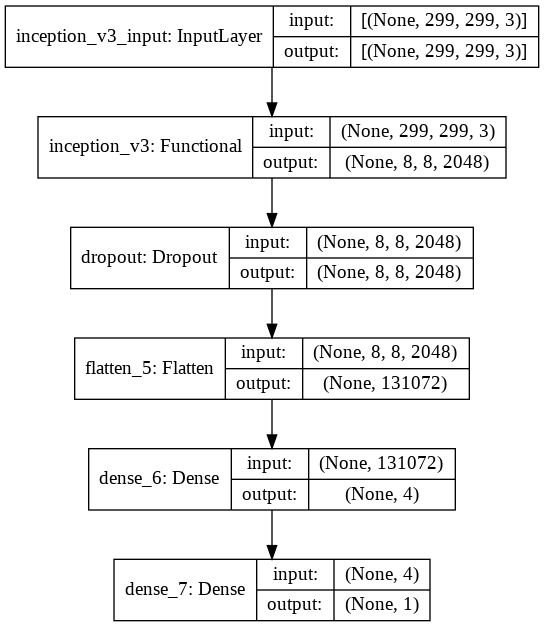

In [ ]:
plot_model(base_model, to_file='base_model.png', show_shapes=True)

In [ ]:
base_model.compile(optimizer=tf.keras.optimizers.RMSprop(learning_rate=0.00002), 
              loss='binary_crossentropy',
              metrics=["accuracy", tf.keras.metrics.Precision(name='precision')])
base_history = base_model.fit(train_level5_label_ds,validation_data=valid_level5_label_ds,epochs=10,verbose=1)

Epoch 1/10
55/55 [==============================] - 36s 475ms/step - loss: 0.6386 - accuracy: 0.6924 - precision: 0.4450 - val_loss: 0.7682 - val_accuracy: 0.5748 - val_precision: 0.2357
Epoch 2/10
55/55 [==============================] - 25s 455ms/step - loss: 0.4384 - accuracy: 0.7940 - precision: 0.6476 - val_loss: 0.4901 - val_accuracy: 0.7551 - val_precision: 0.3735
Epoch 3/10
55/55 [==============================] - 25s 458ms/step - loss: 0.2622 - accuracy: 0.8943 - precision: 0.8159 - val_loss: 0.2728 - val_accuracy: 0.9048 - val_precision: 0.7805
Epoch 4/10
55/55 [==============================] - 25s 459ms/step - loss: 0.1765 - accuracy: 0.9197 - precision: 0.8511 - val_loss: 0.2103 - val_accuracy: 0.9116 - val_precision: 0.7358
Epoch 5/10
55/55 [==============================] - 25s 461ms/step - loss: 0.1436 - accuracy: 0.9349 - precision: 0.8744 - val_loss: 0.1715 - val_accuracy: 0.9218 - val_precision: 0.7692
Epoch 6/10
55/55 [==============================] - 25s 462ms/ste

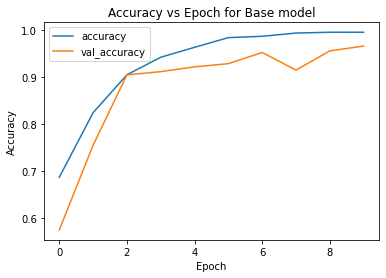

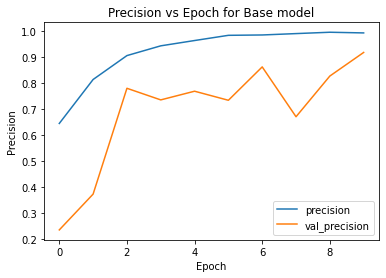

In [ ]:
pd.DataFrame(base_history.history)[['accuracy','val_accuracy']].plot()
plt.title("Accuracy vs Epoch for Base model")
plt.xlabel("Epoch")
plt.ylabel("Accuracy")
plt.show()
pd.DataFrame(base_history.history)[['precision','val_precision']].plot()
plt.title("Precision vs Epoch for Base model")
plt.xlabel("Epoch")
plt.ylabel("Precision")
plt.show()

#####ResNet model

In [ ]:
conv_base = tf.keras.applications.ResNet50(weights='imagenet',include_top=False, input_shape=(IMAGE_SIZE, IMAGE_SIZE, 3))
resnet_model = Sequential()
resnet_model.add(conv_base)
resnet_model.add(Flatten())
resnet_model.add(Dense(32, activation='relu'))
resnet_model.add(Dense(1, activation='sigmoid'))
resnet_model.summary()

94773248/94765736 [==============================] - 1s 0us/step
Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
resnet50 (Functional)        (None, 10, 10, 2048)      23587712  
_________________________________________________________________
flatten_1 (Flatten)          (None, 204800)            0         
_________________________________________________________________
dense_2 (Dense)              (None, 32)                6553632   
_________________________________________________________________
dense_3 (Dense)              (None, 1)                 33        
Total params: 30,141,377
Trainable params: 30,088,257
Non-trainable params: 53,120
_________________________________________________________________


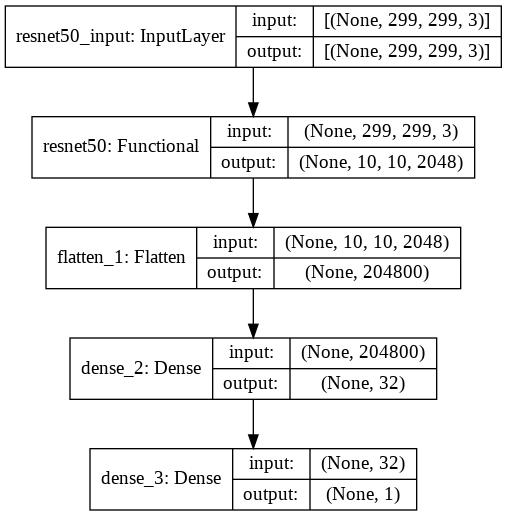

In [ ]:
plot_model(resnet_model, to_file='base_model.png', show_shapes=True)

In [ ]:
resnet_model.compile(optimizer=tf.keras.optimizers.RMSprop(lr=0.0001, rho=0.9, epsilon=None, decay=0.0), 
              loss='binary_crossentropy',
              metrics=["accuracy", tf.keras.metrics.Precision(name='precision')])
resnet_history = resnet_model.fit(train_level5_label_ds,validation_data=valid_level5_label_ds,epochs=10,verbose=1)

Epoch 1/10
55/55 [==============================] - 46s 649ms/step - loss: 0.6370 - accuracy: 0.9086 - precision: 0.8458 - val_loss: 0.9975 - val_accuracy: 0.7143 - val_precision: 0.3701
Epoch 2/10
55/55 [==============================] - 34s 625ms/step - loss: 0.5272 - accuracy: 0.9216 - precision: 0.8605 - val_loss: 4.4286 - val_accuracy: 0.8367 - val_precision: 0.5185
Epoch 3/10
55/55 [==============================] - 34s 622ms/step - loss: 0.5430 - accuracy: 0.9367 - precision: 0.9416 - val_loss: 0.6518 - val_accuracy: 0.9524 - val_precision: 0.8246
Epoch 4/10
55/55 [==============================] - 35s 629ms/step - loss: 0.5133 - accuracy: 0.9317 - precision: 0.9035 - val_loss: 0.8570 - val_accuracy: 0.8878 - val_precision: 0.6184
Epoch 5/10
55/55 [==============================] - 34s 623ms/step - loss: 0.5020 - accuracy: 0.9293 - precision: 0.9155 - val_loss: 1.3901 - val_accuracy: 0.8027 - val_precision: 0.4646
Epoch 6/10
55/55 [==============================] - 35s 627ms/ste

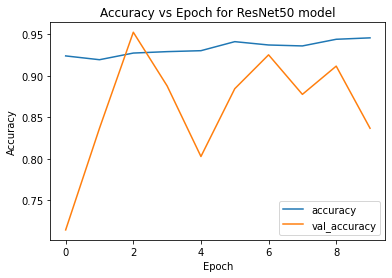

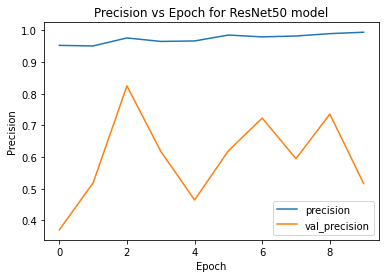

In [ ]:
pd.DataFrame(resnet_history.history)[['accuracy','val_accuracy']].plot()
plt.title("Accuracy vs Epoch for ResNet50 model")
plt.xlabel("Epoch")
plt.ylabel("Accuracy")
plt.show()
pd.DataFrame(resnet_history.history)[['precision','val_precision']].plot()
plt.title("Precision vs Epoch for ResNet50 model")
plt.xlabel("Epoch")
plt.ylabel("Precision")
plt.show()

####Multi-scale model

In [ ]:

# Input to your vision model (activations from Inception-V3,
# loaded off disk disk by the dataset above).
image_input1 = Input(shape=(IMAGE_SIZE, IMAGE_SIZE, 3)) 
first_layer_model = Sequential()
# Used to reduce the number of parameters (rather using a dense layer here).
first_layer_model.add(Conv2D(4, (2, 2), activation='relu', padding='same', input_shape=(IMAGE_SIZE, IMAGE_SIZE, 3)))
first_layer_model.add(BatchNormalization())
first_layer_model.add(MaxPooling2D((2, 2)))
first_layer_model.add(Conv2D(4, (2, 2), activation='relu', padding='same'))
first_layer_model.add(BatchNormalization())
first_layer_model.add(MaxPooling2D((2, 2)))
first_layer_model.add(Conv2D(4, (2, 2), activation='relu', padding='same'))
first_layer_model.add(BatchNormalization())
first_layer_model.add(MaxPooling2D((2, 2)))
first_layer_model.add(tf.keras.layers.GlobalAveragePooling2D())
first_layer_model.add(Flatten())
# Output of your vision model
encoded_first_layer = first_layer_model(image_input1)

image_input2 = Input(shape=(IMAGE_SIZE, IMAGE_SIZE, 3)) 
second_layer_model = Sequential()
second_layer_model.add(Conv2D(4, (2, 2), activation='relu', padding='same', input_shape=(IMAGE_SIZE, IMAGE_SIZE, 3)))
second_layer_model.add(BatchNormalization())
second_layer_model.add(MaxPooling2D((2, 2)))
second_layer_model.add(Conv2D(4, (2, 2), activation='relu', padding='same'))
second_layer_model.add(BatchNormalization())
second_layer_model.add(MaxPooling2D((2, 2)))
second_layer_model.add(Conv2D(4, (2, 2), activation='relu', padding='same'))
second_layer_model.add(BatchNormalization())
second_layer_model.add(MaxPooling2D((2, 2)))
second_layer_model.add(tf.keras.layers.GlobalAveragePooling2D())
second_layer_model.add(Flatten())
encoded_second_layer = second_layer_model(image_input2)

image_input3 = Input(shape=(IMAGE_SIZE, IMAGE_SIZE, 3)) 
third_layer_model = Sequential()
third_layer_model.add(Conv2D(4, (2, 2), activation='relu', padding='same', input_shape=(IMAGE_SIZE, IMAGE_SIZE, 3)))
third_layer_model.add(BatchNormalization())
third_layer_model.add(MaxPooling2D((2, 2)))
third_layer_model.add(Conv2D(4, (2, 2), activation='relu', padding='same'))
third_layer_model.add(BatchNormalization())
third_layer_model.add(MaxPooling2D((2, 2)))
third_layer_model.add(Conv2D(4, (2, 2), activation='relu', padding='same'))
third_layer_model.add(BatchNormalization())
third_layer_model.add(MaxPooling2D((2, 2)))
third_layer_model.add(tf.keras.layers.GlobalAveragePooling2D())
third_layer_model.add(Flatten())
encoded_third_layer = third_layer_model(image_input3) 


# Concatenate the encoded image and question
merged = tf.keras.layers.concatenate([encoded_first_layer, encoded_second_layer,encoded_third_layer])

# Optionally, add a small dense layer
dense = Dense(16, activation='relu')(merged)

# Next, add a binary classifier on top
output = Dense(1, activation='sigmoid')(dense)

# Your final model
multi_scale_model = Model(inputs=[image_input1,image_input2,image_input3], outputs=output)

In [ ]:
multi_scale_model.summary()

Model: "model_3"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_13 (InputLayer)           [(None, 299, 299, 3) 0                                            
__________________________________________________________________________________________________
input_14 (InputLayer)           [(None, 299, 299, 3) 0                                            
__________________________________________________________________________________________________
input_15 (InputLayer)           [(None, 299, 299, 3) 0                                            
__________________________________________________________________________________________________
sequential_12 (Sequential)      (None, 4)            220         input_13[0][0]                   
____________________________________________________________________________________________

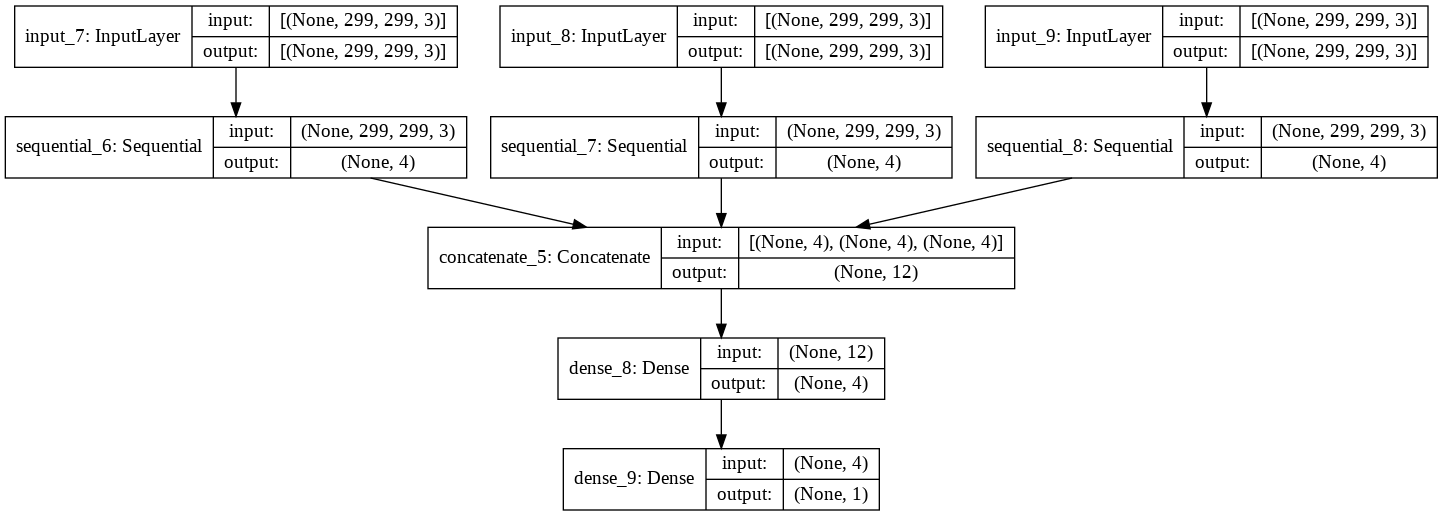

In [ ]:
plot_model(multi_scale_model, to_file='model.png', show_shapes=True)

In [ ]:
multi_scale_model.compile(optimizer=tf.keras.optimizers.RMSprop(lr=0.0001), 
              loss='binary_crossentropy',
              metrics=["accuracy", tf.keras.metrics.Precision(name='precision')])
multi_scale_history = multi_scale_model.fit(train_multi_layer_label_ds,validation_data=valid_multi_layer_label_ds,epochs=10,verbose=1)

Epoch 1/10
55/55 [==============================] - 7s 87ms/step - loss: 0.7301 - accuracy: 0.4759 - precision: 0.2294 - val_loss: 0.5400 - val_accuracy: 0.8673 - val_precision: 0.7500
Epoch 2/10
55/55 [==============================] - 5s 80ms/step - loss: 0.6838 - accuracy: 0.6021 - precision: 0.4256 - val_loss: 0.5487 - val_accuracy: 0.8503 - val_precision: 0.5778
Epoch 3/10
55/55 [==============================] - 5s 80ms/step - loss: 0.6438 - accuracy: 0.7068 - precision: 0.5540 - val_loss: 0.5326 - val_accuracy: 0.8503 - val_precision: 0.5660
Epoch 4/10
55/55 [==============================] - 5s 79ms/step - loss: 0.6110 - accuracy: 0.7404 - precision: 0.6055 - val_loss: 0.5138 - val_accuracy: 0.8401 - val_precision: 0.5345
Epoch 5/10
55/55 [==============================] - 5s 81ms/step - loss: 0.5914 - accuracy: 0.7648 - precision: 0.6373 - val_loss: 0.5017 - val_accuracy: 0.8401 - val_precision: 0.5333
Epoch 6/10
55/55 [==============================] - 5s 81ms/step - loss: 0.

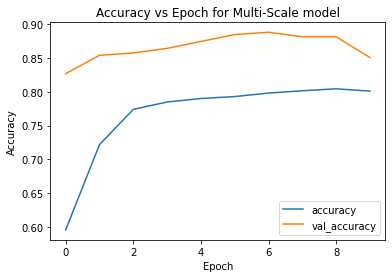

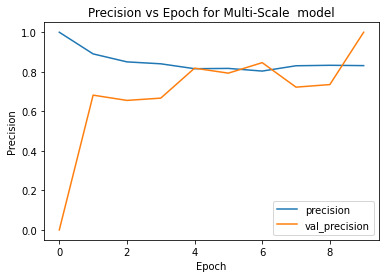

In [ ]:
pd.DataFrame(multi_scale_history.history)[['accuracy','val_accuracy']].plot()
plt.title("Accuracy vs Epoch for Multi-Scale model")
plt.xlabel("Epoch")
plt.ylabel("Accuracy")
plt.show()
pd.DataFrame(multi_scale_history.history)[['precision','val_precision']].plot()
plt.title("Precision vs Epoch for Multi-Scale  model")
plt.xlabel("Epoch")
plt.ylabel("Precision")
plt.show()

###Test

In [ ]:
test_data

,file,mask,slide
0,tumor_016.tif,OpenSlide('/content/drive/MyDrive/CAMELYON16/t...,OpenSlide('/content/drive/MyDrive/CAMELYON16/t...
1,tumor_031.tif,OpenSlide('/content/drive/MyDrive/CAMELYON16/t...,OpenSlide('/content/drive/MyDrive/CAMELYON16/t...
2,tumor_110.tif,OpenSlide('/content/drive/MyDrive/CAMELYON16/t...,OpenSlide('/content/drive/MyDrive/CAMELYON16/t...


In [ ]:
def predict_only_level5(row, model,threshold=0.5):
    base_level = 5
    level5_image = read_slide(row["slide"], x=0, y=0, level=base_level, 
                         width=row["slide"].level_dimensions[base_level][0], 
                         height=row["slide"].level_dimensions[base_level][1])
    mask_image = read_slide(row["mask"], x=0, y=0, level=base_level, 
                         width=row["slide"].level_dimensions[base_level][0], 
                         height=row["slide"].level_dimensions[base_level][1])
    mask_image = mask_image[:,:,0]
    result_mask = np.zeros((level5_image.shape[0], level5_image.shape[1]))
    w = int(level5_image.shape[0]/100) - 1
    h = int(level5_image.shape[1]/100) - 1
    for i in range(1,w):
      for j in range(1,h):
        pixel = level5_image[i*100:i*100+100,j*100:j*100+100,:]
        pmask = mask_image[i*100:i*100+100,j*100:j*100+100]
        if find_tissue_pixel_percent(pixel) > 0.4:
          testimg = level5_image[i*100-100:i*100-100+IMAGE_SIZE,j*100-100:j*100-100+IMAGE_SIZE,:]
          pred = model.predict(tf.expand_dims(testimg,0))
          label = np.max(pmask)
          if pred[0][0]>threshold:
              result_mask[i*100:i*100+100,j*100:j*100+100] = 1
          if pred[0][0]<threshold:
              result_mask[i*100:i*100+100,j*100:j*100+100] = 0
    return result_mask, level5_image, mask_image
def predict_multip_layer(row, model,threshold=0.5):
    base_level = 5
    level5_image = read_slide(row["slide"], x=0, y=0, level=base_level, 
                         width=row["slide"].level_dimensions[base_level][0], 
                         height=row["slide"].level_dimensions[base_level][1])
    level6_image = read_slide(row["slide"], x=0, y=0, level=6, 
                         width=row["slide"].level_dimensions[6][0], 
                         height=row["slide"].level_dimensions[6][1])
    level7_image = read_slide(row["slide"], x=0, y=0, level=7, 
                         width=row["slide"].level_dimensions[7][0], 
                         height=row["slide"].level_dimensions[7][1])
    mask_image = read_slide(row["mask"], x=0, y=0, level=base_level, 
                         width=row["slide"].level_dimensions[base_level][0], 
                         height=row["slide"].level_dimensions[base_level][1])
    mask_image = mask_image[:,:,0]
    result_mask = np.zeros((level5_image.shape[0], level5_image.shape[1]))
    w = int(level5_image.shape[0]/100) - 1
    h = int(level5_image.shape[1]/100) - 1
    for i in range(1,w):
      for j in range(1,h):
        pixel = level5_image[i*100:i*100+100,j*100:j*100+100,:]
        pmask = mask_image[i*100:i*100+100,j*100:j*100+100]
        if find_tissue_pixel_percent(pixel) > 0.4:
          level5_testimg = level5_image[i*100-100:i*100-100+IMAGE_SIZE,j*100-100:j*100-100+IMAGE_SIZE,:]
          level6_testimg = level6_image[i*50-125:i*50-125+IMAGE_SIZE,j*50-125:j*50-125+IMAGE_SIZE,:]
          level7_testimg = level7_image[i*25-137:i*25-137+IMAGE_SIZE,j*25-137:j*25-137+IMAGE_SIZE,:]
          if checkshape(level5_testimg) and checkshape(level6_testimg) and checkshape(level7_testimg):
            pred = model.predict([tf.expand_dims(level5_testimg,0),tf.expand_dims(level6_testimg,0),tf.expand_dims(level7_testimg,0)])
            label = np.max(pmask)
            if pred[0][0]>threshold:
                result_mask[i*100:i*100+100,j*100:j*100+100] = 1
            if pred[0][0]<threshold:
                result_mask[i*100:i*100+100,j*100:j*100+100] = 0
    return result_mask, level5_image, mask_image

In [ ]:
def plot_predict_mask(pred_mask, cur_slide, cur_mask):
  plt.figure(figsize=(20,10))
  plt.subplot(1,4,1)
  plt.imshow(cur_slide)
  plt.imshow(cur_mask,cmap='jet', alpha=0.5)
  plt.title("tumor area")
  plt.grid(False)
  plt.subplot(1,4,2)
  plt.imshow(cur_mask)
  plt.title("tumor mask")
  plt.grid(False)
  plt.subplot(1,4,3)
  plt.imshow(pred_mask)
  plt.title("predict mask")
  plt.grid(False)
  plt.subplot(1,4,4)
  plt.imshow(pred_mask)
  plt.title("tumor mask and predict mask compare")
  plt.imshow(cur_mask)
  plt.imshow(pred_mask,cmap='jet', alpha=0.5)
  plt.grid(False)
  plt.show()

####Base Model Test

Time use: 7.961568355560303 s


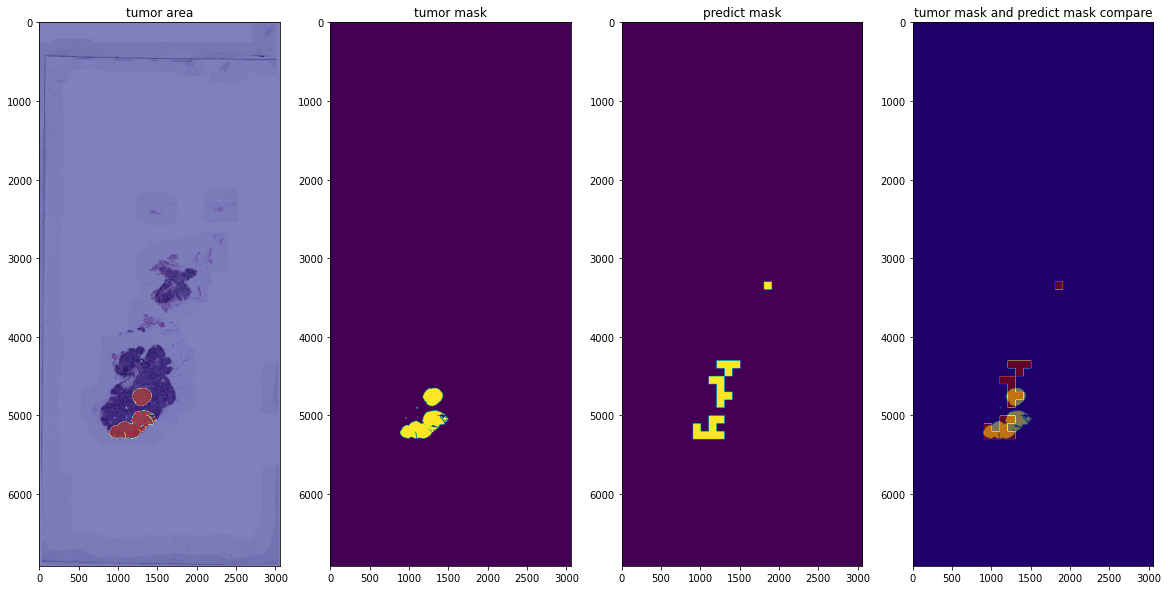

In [ ]:
row1 = test_data.iloc[0]
start = time.time()
pred_mask, cur_slide, cur_mask = predict_only_level5(row1,base_model)
print("Time use:", time.time() - start,"s")
plot_predict_mask(pred_mask, cur_slide, cur_mask)

Time use: 5.531006097793579 s


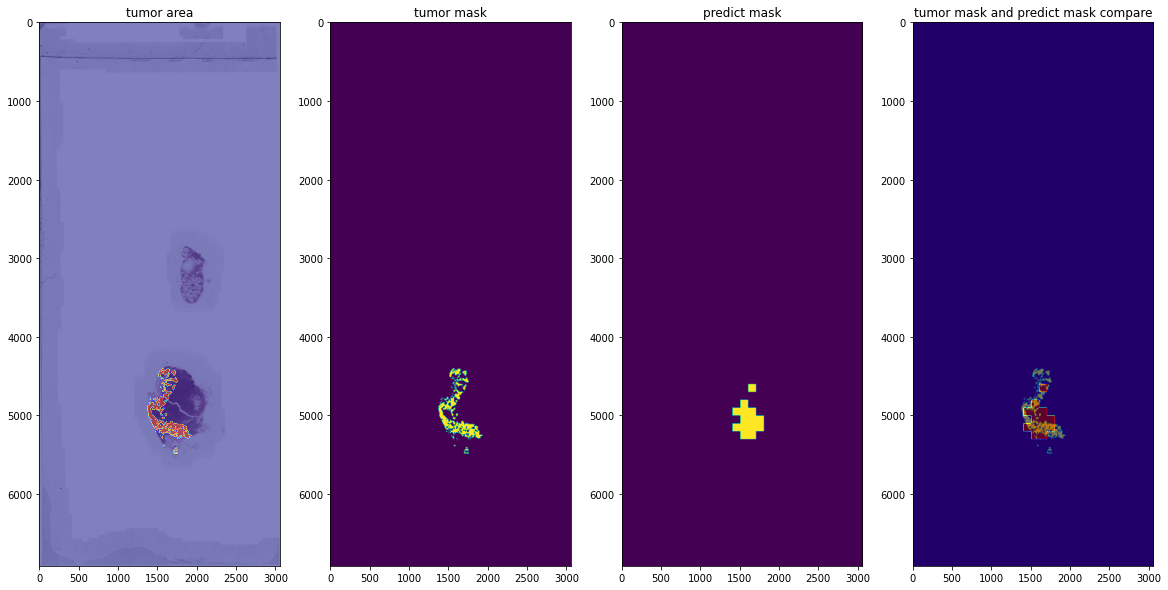

In [ ]:
row1 = test_data.iloc[1]
start = time.time()
pred_mask, cur_slide, cur_mask = predict_only_level5(row1,base_model)
print("Time use:", time.time() - start,"s")
plot_predict_mask(pred_mask, cur_slide, cur_mask)

Time use: 11.904641151428223 s


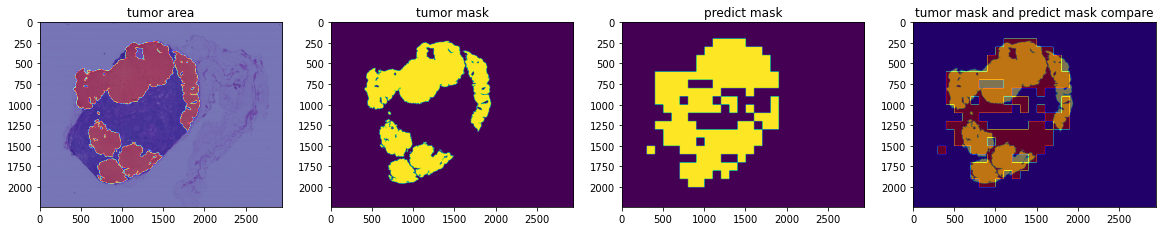

In [ ]:
row1 = test_data.iloc[2]
start = time.time()
pred_mask, cur_slide, cur_mask = predict_only_level5(row1,base_model)
print("Time use:", time.time() - start,"s")
plot_predict_mask(pred_mask, cur_slide, cur_mask)

####ResNet model test

Time use: 7.121540069580078 s


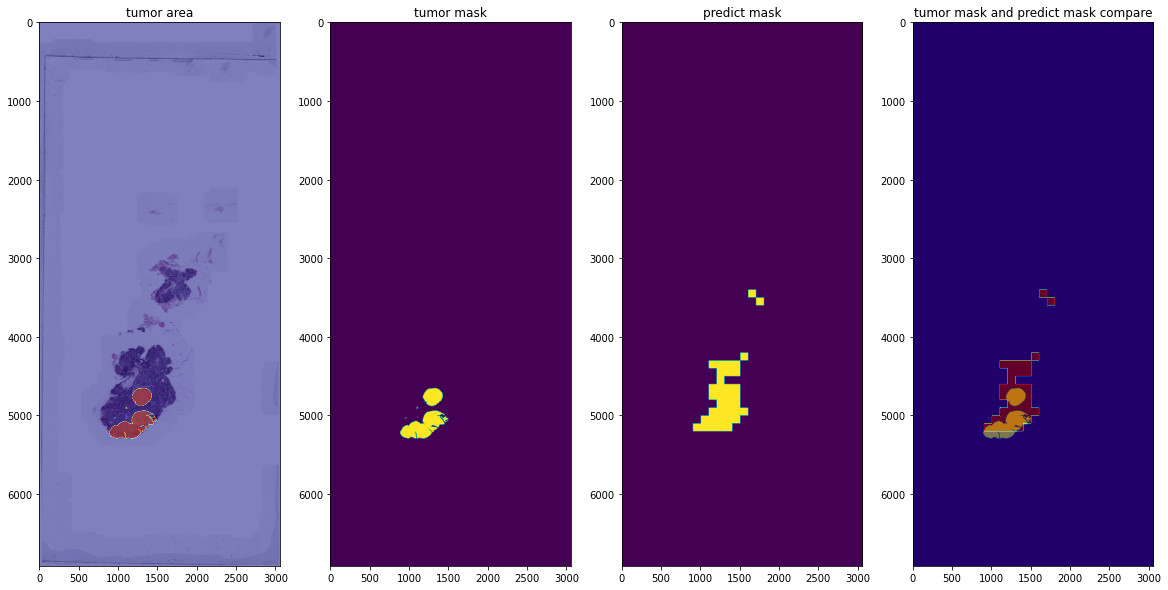

In [ ]:
row1 = test_data.iloc[0]
start = time.time()
pred_mask, cur_slide, cur_mask = predict_only_level5(row1,resnet_model)
print("Time use:", time.time() - start,"s")
plot_predict_mask(pred_mask, cur_slide, cur_mask)

Time use: 5.222930908203125 s


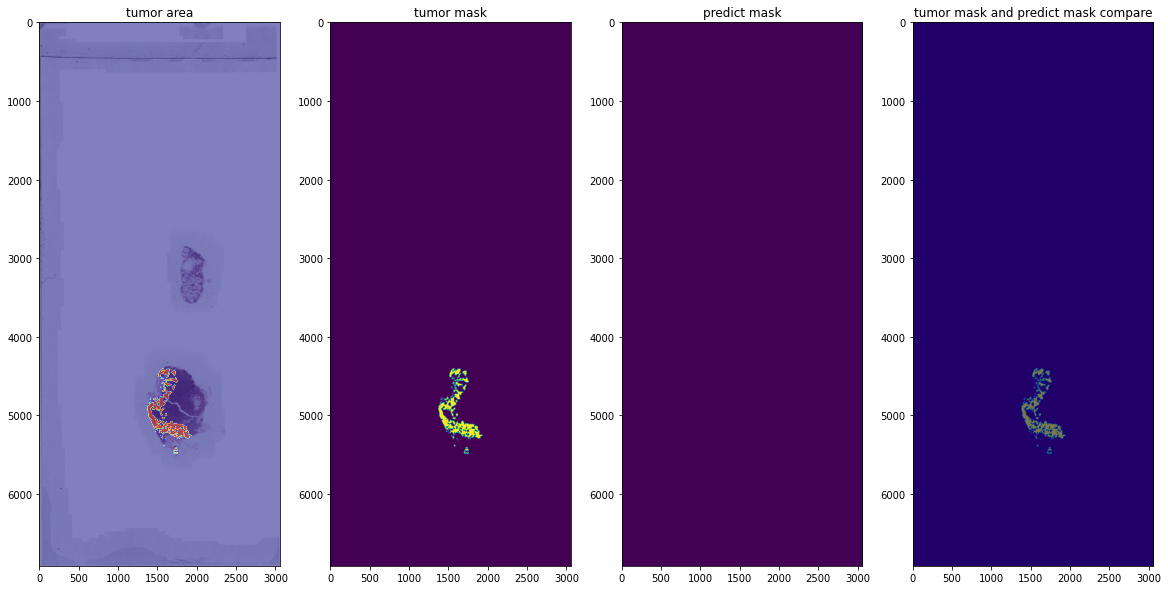

In [ ]:
row1 = test_data.iloc[1]
start = time.time()
pred_mask, cur_slide, cur_mask = predict_only_level5(row1,resnet_model)
print("Time use:", time.time() - start,"s")
plot_predict_mask(pred_mask, cur_slide, cur_mask)

Time use: 10.31654953956604 s


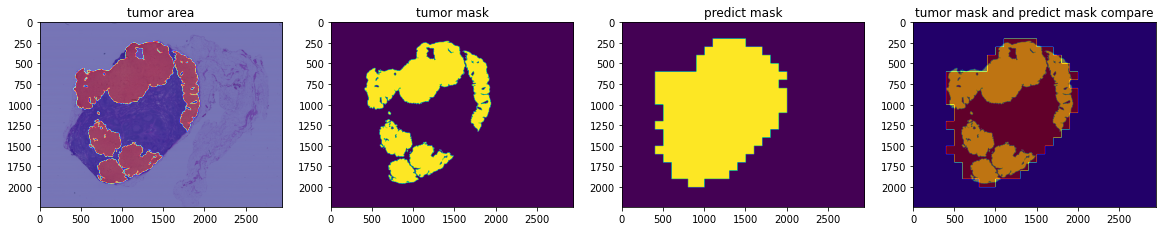

In [ ]:
row1 = test_data.iloc[2]
start = time.time()
pred_mask, cur_slide, cur_mask = predict_only_level5(row1,resnet_model)
print("Time use:", time.time() - start,"s")
plot_predict_mask(pred_mask, cur_slide, cur_mask)

####Multi-Scale model test

Time use: 6.320406675338745 s


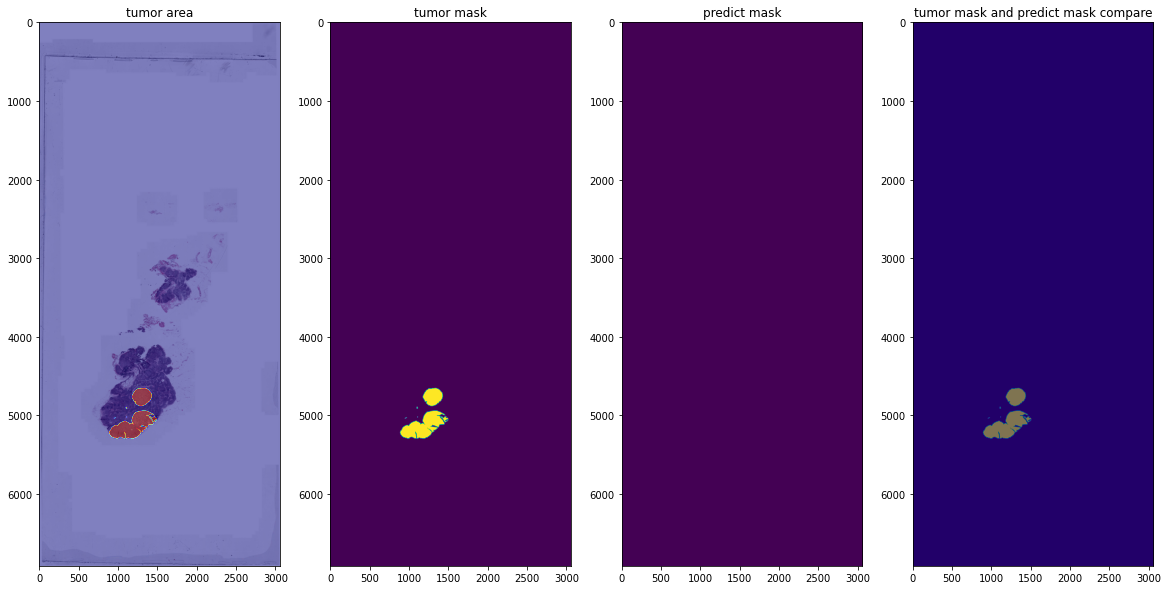

In [ ]:
row1 = test_data.iloc[0]
start = time.time()
pred_mask, cur_slide, cur_mask = predict_multip_layer(row1,multi_scale_model)
print("Time use:", time.time() - start,"s")
plot_predict_mask(pred_mask, cur_slide, cur_mask)

Time use: 5.349445104598999 s


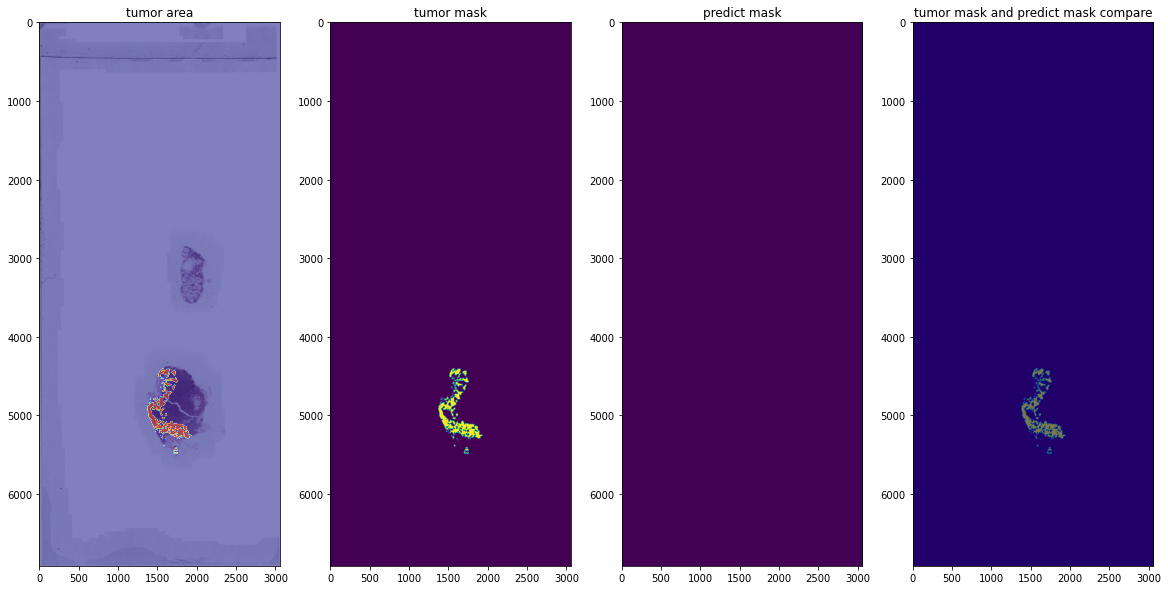

In [ ]:
row1 = test_data.iloc[1]
start = time.time()
pred_mask, cur_slide, cur_mask = predict_multip_layer(row1,multi_scale_model)
print("Time use:", time.time() - start,"s")
plot_predict_mask(pred_mask, cur_slide, cur_mask)

Time use: 5.745373249053955 s


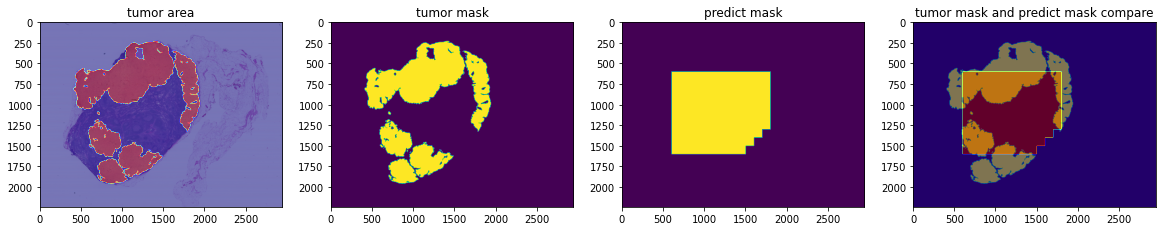

In [ ]:
row1 = test_data.iloc[2]
start = time.time()
pred_mask, cur_slide, cur_mask = predict_multip_layer(row1,multi_scale_model)
print("Time use:", time.time() - start,"s")
plot_predict_mask(pred_mask, cur_slide, cur_mask)